# Kaggle

В этом домашнем задании нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

In [2]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [ ]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [12]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


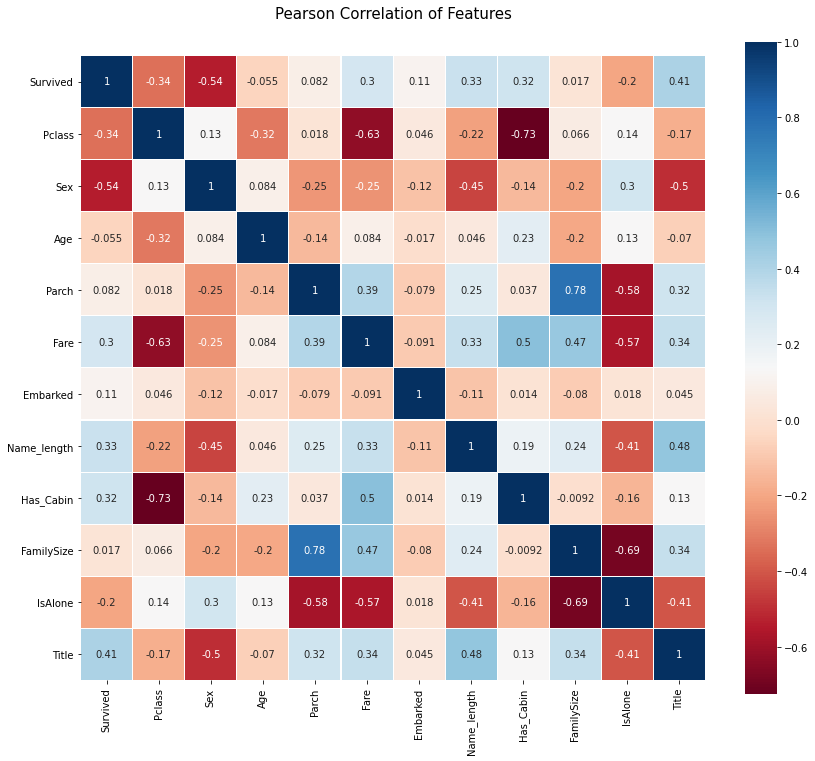

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

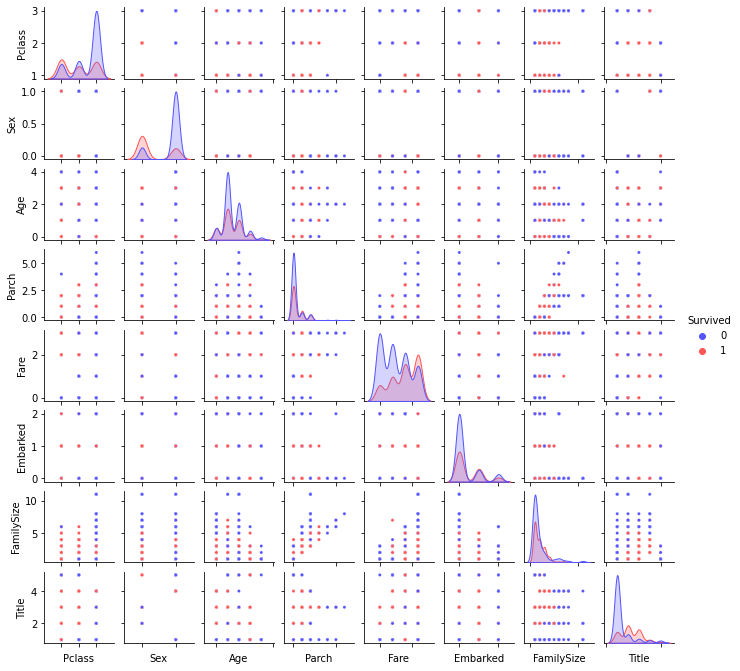

In [13]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуемся алгоритмом стекинга В качестве базовых алгоритмов используем RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделим данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмем столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [66]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold,
                                     cross_val_predict)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)

gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(random_state=17)
svc = SVC(random_state=17)
lr = LogisticRegression(random_state=17)

models = [gbc, rfc, svc, lr]
parametrs = [gbc_params, rfc_params, svc_params, lr_params]

In [62]:
 y = train.iloc[:, 0]
 X = train.iloc[:, 1:]
 X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=17, test_size=0.3)

### 2.


In [49]:
# обучим все модели из 1-го пункта
models_CV = []
for model, param in zip(models, parametrs):
    models_CV.append(GridSearchCV(model, 
                         param, 
                         cv=skf).fit(X_train, y_train))

In [51]:
# выведем лучшие параметры обученных моделей
for model in model_CV:
    print(f'Best params of {type(model.estimator).__name__} are {model.best_params_}')


Best params of GradientBoostingClassifier are {'learning_rate': 0.1}
Best params of RandomForestClassifier are {'min_samples_leaf': 4, 'n_estimators': 20}
Best params of SVC are {'C': 0.30000000000000004, 'kernel': 'linear'}
Best params of LogisticRegression are {'C': 0.7}


In [53]:
from sklearn.metrics import accuracy_score

for model in model_CV:
    print(f'Accuracy of {type(model.estimator).__name__} is {accuracy_score(y_val, model.predict(X_val)):.3f}')


Accuracy of GradientBoostingClassifier is 0.776
Accuracy of RandomForestClassifier is 0.799
Accuracy of SVC is 0.761
Accuracy of LogisticRegression is 0.791


In [54]:
meta_mtrx = np.empty((X_val.shape[0], len(models_CV)))
for n, model in enumerate(models_CV):
            meta_mtrx[:, n] = model.predict(X_val)

### 3.


In [57]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [58]:
xbg = XGBClassifier(random_state=17)
xbg_CV = GridSearchCV(xbg, 
                      xgb_params, 
                      cv=5).fit(meta_mtrx, y_val)

In [59]:
xbg_CV.best_params_

{'eta': 0.1,
 'min_child_weight': 2,
 'n_estimators': 15,
 'subsample': 0.9000000000000001}

In [64]:
def stacking(models, meta_alg, data_train, targets_train, 
             data_test, targets_test=None, random_state=None, 
             test_size=None, cv=5):
    if test_size is None:
        meta_mtrx = np.empty((data_train.shape[0], len(models)))
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        
        for n, model in enumerate(models):
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv=cv, method='predict')
            model.fit(data_train, targets_train)
            meta_mtrx_test[:, n] = model.predict(data_test)
            
        meta = meta_alg
        meta.fit(meta_mtrx, targets_train)      

        meta_predict = meta.predict(meta_mtrx_test)
        
        if targets_test is not None:
            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')
        return meta_predict
        
        
    
    elif test_size > 0 and test_size < 1:
        train, valid, train_true, valid_true = train_test_split(data_train, 
                                                        targets_train,
                                                        test_size=test_size,
                                                        random_state=random_state)
        
        meta_mtrx = np.empty((valid.shape[0], len(models)))
        meta_mtrx_test = np.empty((x_test.shape[0], len(models)))

        for n, model in enumerate(models):
            model.fit(train, train_true)
            meta_mtrx[:, n] = model.predict(valid)
            meta_mtrx_test[:, n] = model.predict(data_test)
        
        meta = meta_alg
        meta.fit(meta_mtrx, valid_true)      

        meta_predict = meta.predict(meta_mtrx_test)
        
        if targets_test is not None:
            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')
            
        return meta_predict
    
    else:
        raise ValueError("test_size must be between 0 and 1")

In [ ]:
predict = stacking(models_CV, xbg_CV, X, y, test, random_state=17, test_size=None, cv=5)

### 5.


In [83]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [93]:
write_to_submission_file(predict, PassengerId)

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ:
0.77990

